## Librerias

In [33]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.optimize import minimize

## Datos

In [34]:
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Activos")
retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
# Cambiar nombres de columnas: de '.' a '-' en retornos
retornos.columns = retornos.columns.str.replace(".", "-")

In [35]:
ltm_extremo = retornos[np.isclose(retornos["LTM"], -1.75, atol=0.01)]
ltm_extremo

,AGUAS-A,CHILE,BCI,ITAUCL,BSANTANDER,CAP,CENCOSUD,COLBUN,CCU,VAPORES,...,LTM,PARAUCO,MALLPLAZA,QUINENCO,RIPLEY,SALFACORP,SMU,SQM-B,SONDA,CONCHATORO
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-09-08,-0.006198,-0.001163,-0.022306,-0.021702,0.005219,-0.007615,-0.011516,-0.011272,-0.02444,-0.047057,...,-1.75028,-0.021053,-0.049283,0.000855,-0.04694,-0.061558,-0.018374,0.043012,-0.026333,-0.015471


In [36]:
retornos.loc["2022-09-07"]

AGUAS-A      -0.029429
CHILE        -0.017291
BCI          -0.035573
ITAUCL       -0.008946
BSANTANDER   -0.018554
CAP          -0.025197
CENCOSUD     -0.028595
COLBUN       -0.010929
CCU          -0.010151
VAPORES      -0.031509
ANDINA-B      0.002187
ENTEL         0.003480
CMPC         -0.011478
COPEC         0.001429
ENELAM        0.000000
ENELCHILE    -0.006768
ECL          -0.030035
FALABELLA    -0.011300
SECURITY     -0.018580
IAM          -0.036803
LTM          -0.069334
PARAUCO      -0.020619
MALLPLAZA    -0.036682
QUINENCO     -0.002178
RIPLEY       -0.036430
SALFACORP    -0.014815
SMU          -0.034569
SQM-B         0.004191
SONDA        -0.047117
CONCHATORO    0.015565
Name: 2022-09-07 00:00:00, dtype: float64

In [37]:
# Calcular estadísticas descriptivas
estadisticas = pd.DataFrame({
    "Promedio": retornos.mean(),
    "Desviacion_Estandar": retornos.std(),
    "Minimo": retornos.min(),
    "Maximo": retornos.max(),
    "Mediana": retornos.median()
})

# Redondear a 4 decimales
estadisticas_rounded = estadisticas.round(4)

# Generar tabla LaTeX con caption
latex_table = estadisticas_rounded.to_latex(
    caption="Estadísticas descriptivas de los retornos diarios por activo. Se presenta el promedio, la desviación estándar, el mínimo, el máximo y la mediana durante el período analizado.",
    label="tab:estadisticas_retornos",
    index=True,
    escape=False,
    column_format="lrrrrr"
)

# Mostrar
print(latex_table)

\begin{table}
\caption{Estadísticas descriptivas de los retornos diarios por activo. Se presenta el promedio, la desviación estándar, el mínimo, el máximo y la mediana durante el período analizado.}
\label{tab:estadisticas_retornos}
\begin{tabular}{lrrrrr}
\toprule
 & Promedio & Desviacion_Estandar & Minimo & Maximo & Mediana \\
\midrule
AGUAS-A & 0.001000 & 0.017000 & -0.061600 & 0.093200 & 0.000000 \\
CHILE & 0.000700 & 0.013400 & -0.090700 & 0.049600 & 0.000200 \\
BCI & 0.000300 & 0.015600 & -0.097100 & 0.056600 & 0.000000 \\
ITAUCL & 0.012400 & 0.316100 & -0.061500 & 8.426200 & 0.000000 \\
BSANTANDER & 0.000600 & 0.014200 & -0.082500 & 0.050900 & 0.000200 \\
CAP & -0.000700 & 0.023600 & -0.127700 & 0.098300 & -0.001100 \\
CENCOSUD & 0.000900 & 0.016300 & -0.081600 & 0.074600 & 0.000900 \\
COLBUN & 0.000800 & 0.018600 & -0.082300 & 0.118900 & 0.000000 \\
CCU & -0.000000 & 0.016300 & -0.052600 & 0.071000 & 0.000000 \\
VAPORES & -0.000300 & 0.028500 & -0.319600 & 0.151800 & 0.000000 \

## Portafolio

In [38]:
# PARÁMETROS
mean_returns = retornos.mean()
num_assets = len(mean_returns)
rf = 0.0474 / 252  # tasa libre de riesgo diaria

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

In [39]:
# FUNCIONES DE OPTIMIZACIÓN
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    ret, risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - risk_free_rate) / risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Portafolio de máximo retorno esperado
def neg_return(weights, mean_returns):
    return -np.dot(weights, mean_returns)

# FUNCIÓN PARA MOSTRAR RESULTADOS
def mostrar_resultados(resultado, nombre):
    ret, risk = portfolio_performance(resultado.x, mean_returns, cov_matrix)
    sharpe = (ret - rf) / risk
    print(f"\n{nombre}")
    print(f"Retorno esperado: {ret:.5f}")
    print(f"Riesgo (desviación estándar): {risk:.5f}")
    print(f"Sharpe Ratio: {sharpe:.5f}")
    pesos = pd.Series(resultado.x, index=retornos.columns)
    print("\nPesos del portafolio:")
    print(pesos.round(4))
    return pd.DataFrame(pesos.round(4), columns=[nombre])

In [40]:
# CÁLCULO DE ESTADÍSTICAS
mean_returns = retornos.mean()
cov_matrix = retornos.cov()
num_assets = len(mean_returns)

# RESTRICCIONES Y PARÁMETROS
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# OPTIMIZACIÓN 
# Portafolio de mínima varianza
res_min_var = minimize(min_variance, initial_guess, args=(cov_matrix,),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Portafolio de máximo retorno esperado
res_max_ret = minimize(neg_return, initial_guess, args=(mean_returns,),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Portafolio de máximo Sharpe
res_max_sharpe = minimize(neg_sharpe_ratio, initial_guess,
                          args=(mean_returns, cov_matrix, rf),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# RESULTADOS
# MOSTRAR LOS RESULTADOS DE CADA PORTAFOLIO
resultado_1_min = mostrar_resultados(res_min_var, "Portafolio de Mínima Varianza")
resultado_1_max = mostrar_resultados(res_max_ret, "Portafolio de Máximo Retorno Esperado")
resultado_1_sharpe = mostrar_resultados(res_max_sharpe, "Portafolio de Máximo Sharpe Ratio")


Portafolio de Mínima Varianza
Retorno esperado: 0.00046
Riesgo (desviación estándar): 0.00925
Sharpe Ratio: 0.02896

Pesos del portafolio:
AGUAS-A       0.0347
CHILE         0.0349
BCI           0.0346
ITAUCL        0.0010
BSANTANDER    0.0347
CAP           0.0343
CENCOSUD      0.0347
COLBUN        0.0346
CCU           0.0348
VAPORES       0.0343
ANDINA-B      0.0349
ENTEL         0.0348
CMPC          0.0345
COPEC         0.0345
ENELAM        0.0348
ENELCHILE     0.0345
ECL           0.0344
FALABELLA     0.0345
SECURITY      0.0349
IAM           0.0346
LTM           0.0295
PARAUCO       0.0346
MALLPLAZA     0.0347
QUINENCO      0.0347
RIPLEY        0.0345
SALFACORP     0.0345
SMU           0.0348
SQM-B         0.0341
SONDA         0.0347
CONCHATORO    0.0350
dtype: float64

Portafolio de Máximo Retorno Esperado
Retorno esperado: 0.01238
Riesgo (desviación estándar): 0.31608
Sharpe Ratio: 0.03856

Pesos del portafolio:
AGUAS-A       0.0
CHILE         0.0
BCI           0.0
ITAUCL       

## Integración factor de ajuste

In [41]:
def mostrar_resultados(resultado, nombre, cov_matrix):
    ret, risk = portfolio_performance(resultado.x, mean_returns, cov_matrix)
    sharpe = (ret - rf) / risk
    print(f"\n{nombre}")
    print(f"Retorno esperado: {ret:.5f}")
    print(f"Riesgo (desviación estándar): {risk:.5f}")
    print(f"Sharpe Ratio: {sharpe:.5f}")
    pesos = pd.Series(resultado.x, index=retornos.columns)
    print("\nPesos del portafolio:")
    print(pesos.round(4))
    return pd.DataFrame(pesos.round(4), columns=[nombre])

In [42]:
# CARGAR DATOS
archivo = "Datos_Portafolio_Markowitz.xlsx"
ajustes_df = pd.read_excel(archivo, sheet_name="Probabilidades")
ajustes = ajustes_df.set_index("Activo")["Ajuste"]

# Asegurar que nombres coincidan
retornos = retornos[ajustes.index]

# CONSTRUIR MATRIZ DE COVARIANZA AJUSTADA
# Matriz de correlación original
cor_matrix = retornos.corr()
# Desviaciones estándar históricas
std_original = retornos.std()
# Desviaciones ajustadas
peso = 0.8
ajustes = 1 - peso * ajustes
std_ajustada = std_original * ajustes
# Nueva matriz de covarianza ajustada
cov_ajustada = np.outer(std_ajustada, std_ajustada) * cor_matrix
cov_ajustada = pd.DataFrame(cov_ajustada, index=ajustes.index, columns=ajustes.index)

# OPTIMIZACIÓN
res_min_var_adj = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                           method='SLSQP', bounds=bounds, constraints=constraints)

res_max_ret_adj = minimize(neg_return, initial_guess, args=(mean_returns,),
                           method='SLSQP', bounds=bounds, constraints=constraints)

res_max_sharpe_adj = minimize(neg_sharpe_ratio, initial_guess,
                              args=(mean_returns, cov_ajustada, rf),
                              method='SLSQP', bounds=bounds, constraints=constraints)


# VISUALIZAR
resultado_2_min = mostrar_resultados(res_min_var_adj, "Portafolio de Mínima Varianza (Ajustado)", cov_ajustada)
resultado_2_max = mostrar_resultados(res_max_ret_adj, "Portafolio de Máximo Retorno (Ajustado)", cov_ajustada)
resultado_2_sharpe = mostrar_resultados(res_max_sharpe_adj, "Portafolio de Máximo Sharpe (Ajustado)", cov_ajustada)


Portafolio de Mínima Varianza (Ajustado)
Retorno esperado: 0.00058
Riesgo (desviación estándar): 0.00953
Sharpe Ratio: 0.04068

Pesos del portafolio:
AGUAS-A       0.0369
CHILE         0.0383
BCI           0.0346
ITAUCL        0.0007
BSANTANDER    0.0363
CAP           0.0318
CENCOSUD      0.0379
COLBUN        0.0365
CCU           0.0355
VAPORES       0.0319
ANDINA-B      0.0391
ENTEL         0.0365
CMPC          0.0351
COPEC         0.0336
ENELAM        0.0381
ENELCHILE     0.0333
ECL           0.0333
FALABELLA     0.0337
SECURITY      0.0397
IAM           0.0363
LTM           0.0000
PARAUCO       0.0373
MALLPLAZA     0.0375
QUINENCO      0.0358
RIPLEY        0.0339
SALFACORP     0.0335
SMU           0.0373
SQM-B         0.0294
SONDA         0.0376
CONCHATORO    0.0384
dtype: float64

Portafolio de Máximo Retorno (Ajustado)
Retorno esperado: 0.01238
Riesgo (desviación estándar): 0.23635
Sharpe Ratio: 0.05157

Pesos del portafolio:
AGUAS-A       0.0
CHILE         0.0
BCI           0.0


In [43]:
resultados = pd.concat([resultado_1_min, resultado_2_min, resultado_1_max, resultado_2_max, resultado_1_sharpe,
                         resultado_2_sharpe], axis=1)

In [44]:
resultados

,Portafolio de Mínima Varianza,Portafolio de Mínima Varianza (Ajustado),Portafolio de Máximo Retorno Esperado,Portafolio de Máximo Retorno (Ajustado),Portafolio de Máximo Sharpe Ratio,Portafolio de Máximo Sharpe (Ajustado)
AGUAS-A,0.0347,0.0369,0.0,0.0,0.1141,0.0776
CHILE,0.0349,0.0383,0.0,0.0,0.0887,0.0985
BCI,0.0346,0.0346,0.0,0.0,0.0000,0.0000
ITAUCL,0.0010,0.0007,1.0,1.0,0.0105,0.0151
BSANTANDER,0.0347,0.0363,0.0,0.0,0.0000,0.0000
CAP,0.0343,0.0318,0.0,0.0,0.0000,0.0000
CENCOSUD,0.0347,0.0379,0.0,0.0,0.0565,0.1227
COLBUN,0.0346,0.0365,0.0,0.0,0.0000,0.0000
CCU,0.0348,0.0355,0.0,0.0,0.0000,0.0000
VAPORES,0.0343,0.0319,0.0,0.0,0.0000,0.0000


## Frontera Eficiente

In [45]:
# Frontera Eficiente Mejorada: Initial Guess = Portafolio anterior
def efficient_frontier_por_riesgo(mean_returns, cov_matrix, port_min, port_max, num_points=300):
    results = np.zeros((2, num_points))
    weights_record = []

    # Riesgo mínimo y máximo
    min_risk = np.sqrt(np.dot(port_min.x.T, np.dot(cov_matrix, port_min.x)))
    max_risk = np.sqrt(np.dot(port_max.x.T, np.dot(cov_matrix, port_max.x)))

    # Definimos los riesgos objetivos
    target_risks = np.linspace(min_risk, max_risk, num_points)

    # Primer initial guess (uniforme)
    initial_guess = np.ones(len(mean_returns)) / len(mean_returns)

    for idx, target in enumerate(target_risks):
        # Restricciones: pesos suman 1 y riesgo menor o igual al target
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: target - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))}
        )

        bounds = tuple((0, 1) for _ in range(len(mean_returns)))

        # Maximizamos el retorno
        result = minimize(lambda x: -np.dot(x, mean_returns),
                          initial_guess,
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)

        if result.success:
            # Guardamos el portafolio encontrado
            weights_record.append(result.x)
            risk = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
            ret = np.dot(result.x, mean_returns)
            results[0, idx] = risk
            results[1, idx] = ret

            # Nuevo initial_guess = portafolio encontrado
            initial_guess = result.x

    return results, weights_record

### Normal

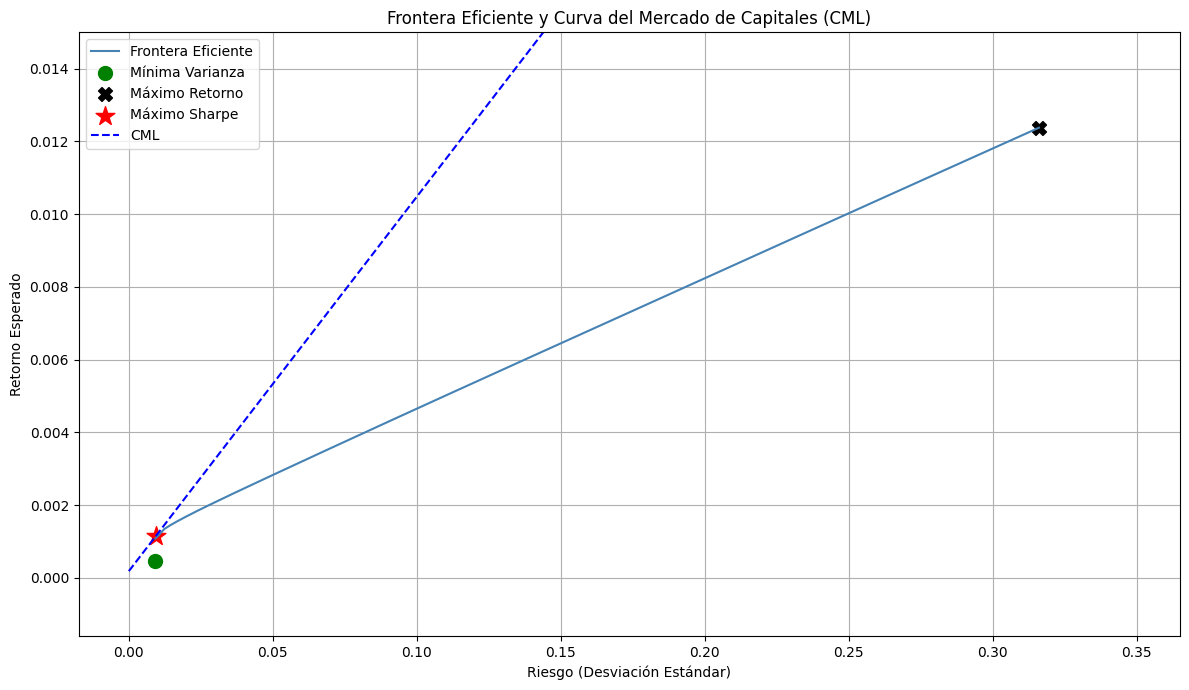

In [46]:
frontier, portfolios = efficient_frontier_por_riesgo(mean_returns, cov_matrix, res_min_var, res_max_ret, num_points=300)

plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var.x, mean_returns, cov_matrix)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret.x, mean_returns, cov_matrix)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe.x, mean_returns, cov_matrix)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Ajustada

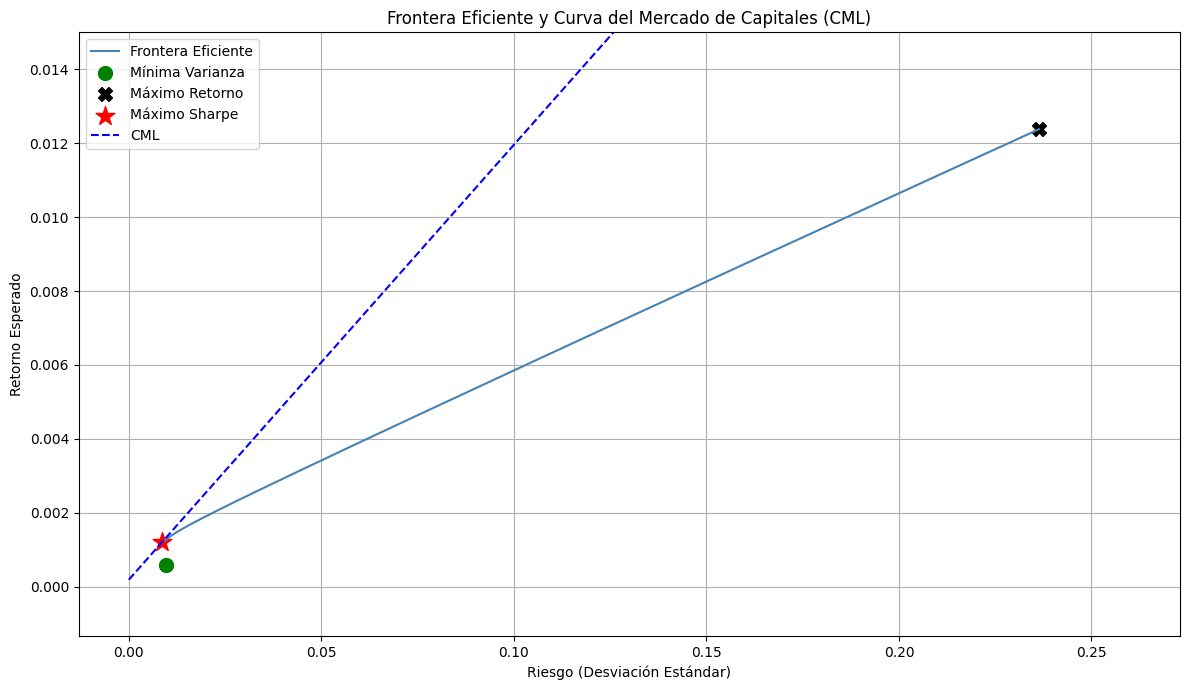

In [47]:
frontier_adj, portfolios_adj = efficient_frontier_por_riesgo(mean_returns, cov_ajustada, res_min_var_adj, res_max_ret_adj, num_points=300)

plt.figure(figsize=(12, 7))
plt.plot(frontier_adj[0, :], frontier_adj[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var_adj, risk_min_var_adj = portfolio_performance(res_min_var_adj.x, mean_returns, cov_ajustada)
ret_max_ret_adj, risk_max_ret_adj = portfolio_performance(res_max_ret_adj.x, mean_returns, cov_ajustada)
ret_max_sharpe_adj, risk_max_sharpe_adj = portfolio_performance(res_max_sharpe_adj.x, mean_returns, cov_ajustada)

plt.scatter(risk_min_var_adj, ret_min_var_adj, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret_adj, ret_max_ret_adj, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe_adj, ret_max_sharpe_adj, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier_adj[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe_adj - rf) / risk_max_sharpe_adj) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
def efficient_frontier_por_retorno(mean_returns, cov_matrix, ret_min, ret_max, num_points=300):
    results = np.zeros((2, num_points))
    weights_record = []

    # Retornos objetivo
    target_returns = np.linspace(ret_min, ret_max, num_points)
    num_assets = len(mean_returns)

    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.ones(num_assets) / num_assets

    for idx, target_ret in enumerate(target_returns):
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_ret}
        )

        result = minimize(min_variance, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            weights = result.x
            risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            ret = np.dot(weights, mean_returns)

            results[0, idx] = risk
            results[1, idx] = ret
            weights_record.append(weights)

            initial_guess = weights  # Mejora de estabilidad

    return results, weights_record


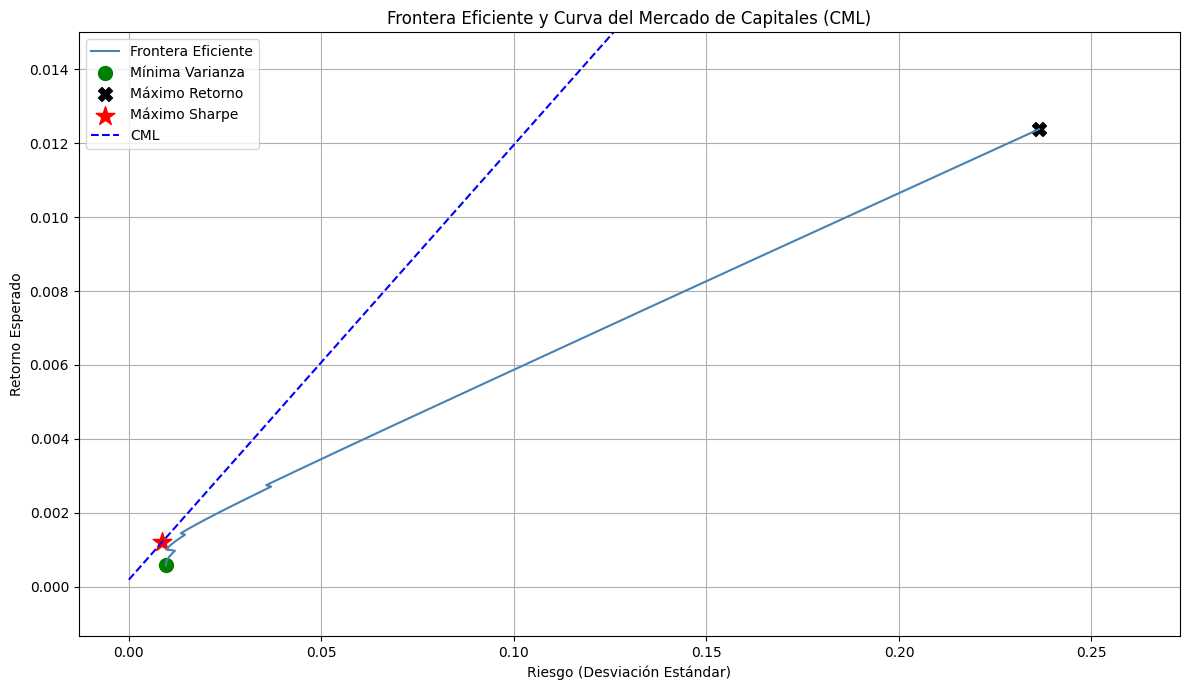

In [49]:
ret_min = np.dot(res_min_var_adj.x, mean_returns)
ret_max = np.dot(res_max_ret_adj.x, mean_returns)

frontier, portfolios = efficient_frontier_por_retorno(mean_returns, cov_ajustada, ret_min, ret_max)
plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var_adj.x, mean_returns, cov_ajustada)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret_adj.x, mean_returns, cov_ajustada)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe_adj.x, mean_returns, cov_ajustada)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

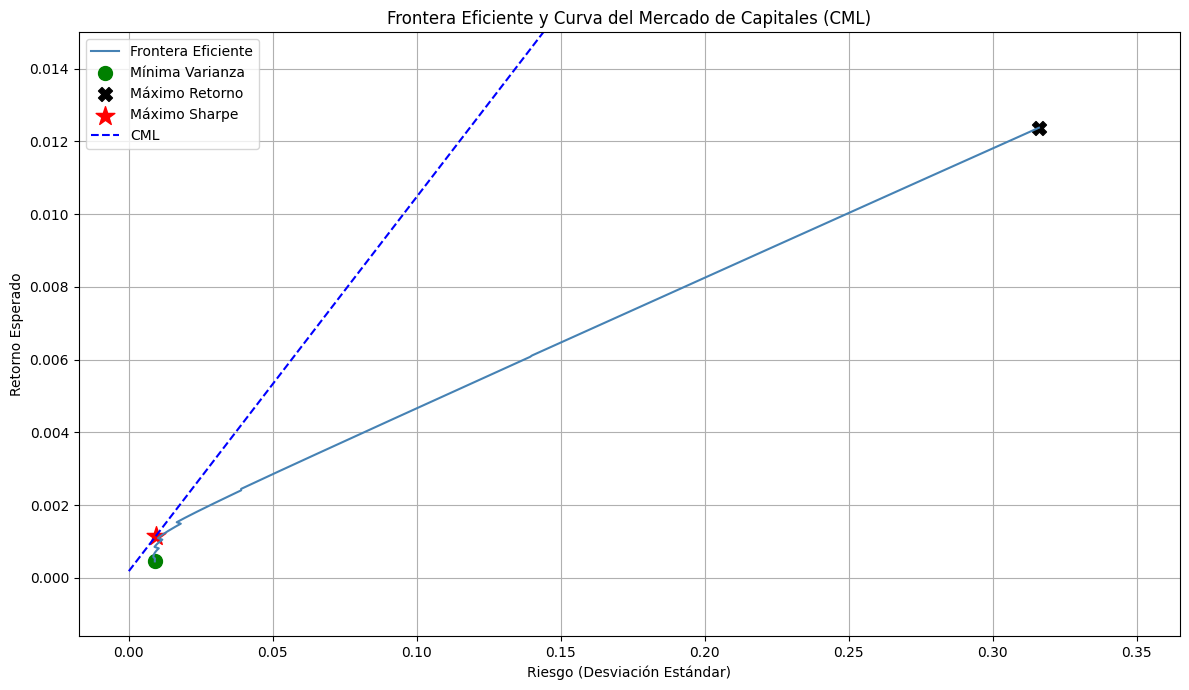

In [50]:
ret_min = np.dot(res_min_var.x, mean_returns)
ret_max = np.dot(res_max_ret.x, mean_returns)

frontier, portfolios = efficient_frontier_por_retorno(mean_returns, cov_matrix, ret_min, ret_max)
plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var.x, mean_returns, cov_matrix)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret.x, mean_returns, cov_matrix)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe.x, mean_returns, cov_matrix)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulaciones

In [51]:
# Cargar los datos
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252  # tasa libre de riesgo diaria
num_assets = retornos.shape[1]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

In [52]:
# Funciones de optimización
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [53]:
# Simulación diaria
retornos_diarios_portafolio = []

for fecha in retornos_2025.index:
    datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
    
    if len(datos_hasta_hoy) < 2:
        continue

    mean_returns = datos_hasta_hoy.mean()
    cov_matrix = datos_hasta_hoy.cov()

    res = minimize(min_variance, initial_guess, args=(cov_matrix,),
                   method='SLSQP', bounds=bounds, constraints=constraints)

    if not res.success:
        continue

    pesos = res.x
    retorno_dia = np.dot(pesos, retornos_2025.loc[fecha])
    retornos_diarios_portafolio.append((fecha, retorno_dia))

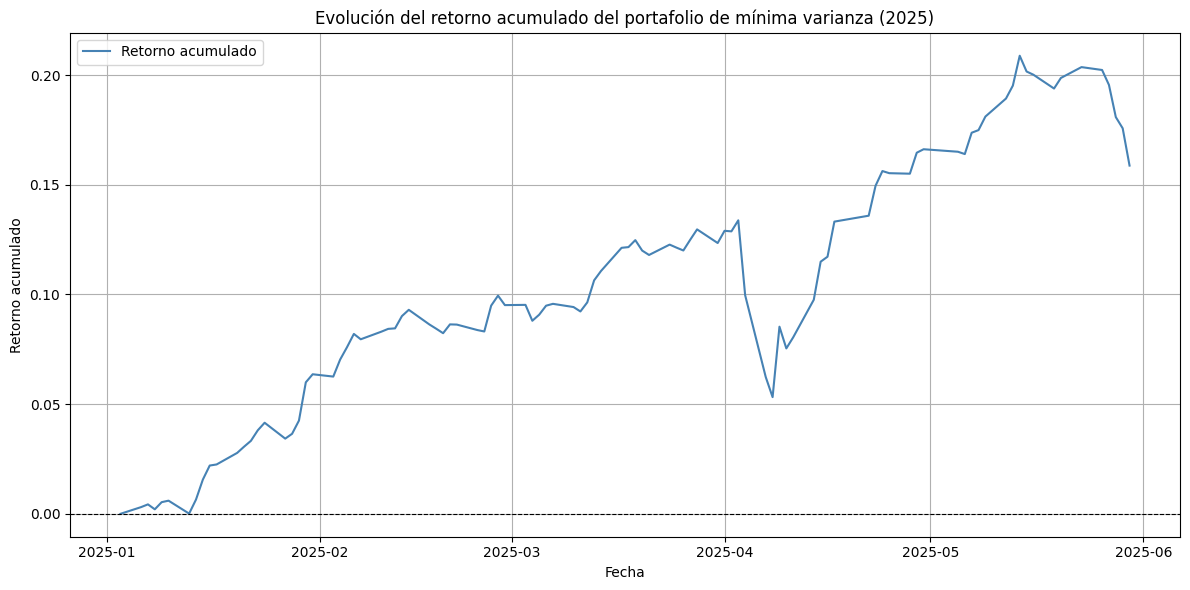

In [54]:
# Convertir resultados a DataFrame
df_simulacion = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
df_simulacion["Retorno_Acumulado"] = (1 + df_simulacion["Retorno"]).cumprod() - 1

# Mostrar gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_simulacion["Fecha"], df_simulacion["Retorno_Acumulado"], label="Retorno acumulado", color="steelblue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Evolución del retorno acumulado del portafolio de mínima varianza (2025)")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Simulación Ajustada

In [55]:
# Funciones
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [56]:
# --- CARGAR DATOS ---
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
df_prob = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Probabilidades")

retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
retornos.columns = retornos.columns.str.strip().str.replace(".", "-")
df_prob["Activo"] = df_prob["Activo"].str.strip()

# Filtrar activos comunes
activos_comunes = list(set(retornos.columns).intersection(df_prob["Activo"]))
retornos = retornos[activos_comunes]
df_prob = df_prob.set_index("Activo").loc[activos_comunes]


# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252  # tasa libre de riesgo diaria
num_assets = retornos.shape[1]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]


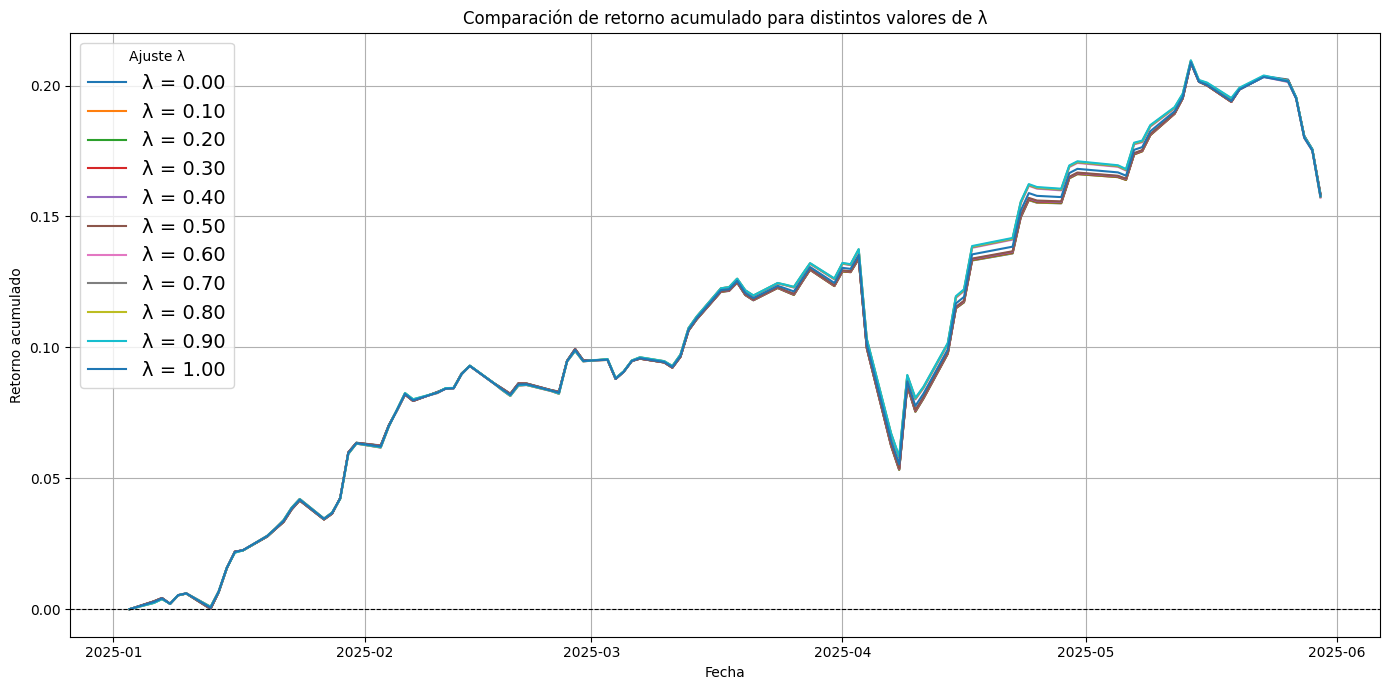

In [57]:
# --- SIMULACIÓN PARA GRID DE LAMBDA ---
lambdas = np.arange(0.0, 1.01, 0.1)
resultados_lambdas = {}

for lambda_ in lambdas:
    retornos_diarios_portafolio = []
    
    for fecha in retornos_2025.index:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_matrix_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        
        # Aplicar ajuste dinámico
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)

        # Matriz de covarianza ajustada
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_matrix_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        # Optimización
        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x
        retorno_dia = np.dot(pesos, retornos_2025.loc[fecha, activos_comunes].values)
        retornos_diarios_portafolio.append((fecha, retorno_dia))
    # Guardar resultados
    df_resultado = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_lambdas[lambda_] = df_resultado

# --- GRAFICAR TODOS LOS RETORNOS ACUMULADOS ---
plt.figure(figsize=(14, 7))

for lambda_, df_sim in resultados_lambdas.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Comparación de retorno acumulado para distintos valores de λ")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="Ajuste λ", fontsize=14)
plt.tight_layout()
plt.show()


In [58]:
series = pd.concat([std_original, std_ajustada], axis = 1)
series

,0,1
CMPC,0.019013,0.019202
SMU,0.016182,0.016915
RIPLEY,0.018196,0.023062
ENTEL,0.020709,0.024253
ECL,0.019238,0.026691
ENELCHILE,0.020510,0.027608
CONCHATORO,0.013062,0.014176
PARAUCO,0.018530,0.015019
FALABELLA,0.017074,0.024412
ITAUCL,0.316077,0.216418



Portafolio de Mínima Varianza (Ajustado)
Retorno esperado: 0.00079
Riesgo (desviación estándar): 0.01400
Sharpe Ratio: 0.04268

Pesos del portafolio:
CMPC          0.0369
SMU           0.0383
RIPLEY        0.0346
ENTEL         0.0007
ECL           0.0363
ENELCHILE     0.0318
CONCHATORO    0.0379
PARAUCO       0.0365
FALABELLA     0.0355
ITAUCL        0.0319
CCU           0.0391
CAP           0.0365
IAM           0.0351
SQM-B         0.0336
LTM           0.0381
AGUAS-A       0.0333
ANDINA-B      0.0333
SALFACORP     0.0337
MALLPLAZA     0.0397
SONDA         0.0363
COLBUN        0.0000
COPEC         0.0373
BSANTANDER    0.0375
ENELAM        0.0358
SECURITY      0.0339
VAPORES       0.0335
CENCOSUD      0.0373
CHILE         0.0294
QUINENCO      0.0376
BCI           0.0384
dtype: float64

Portafolio de Mínima Varianza (Ajustado)
Retorno esperado: 0.00079
Riesgo (desviación estándar): 0.01384
Sharpe Ratio: 0.04317

Pesos del portafolio:
CMPC          0.0369
SMU           0.0383
RIPLEY     

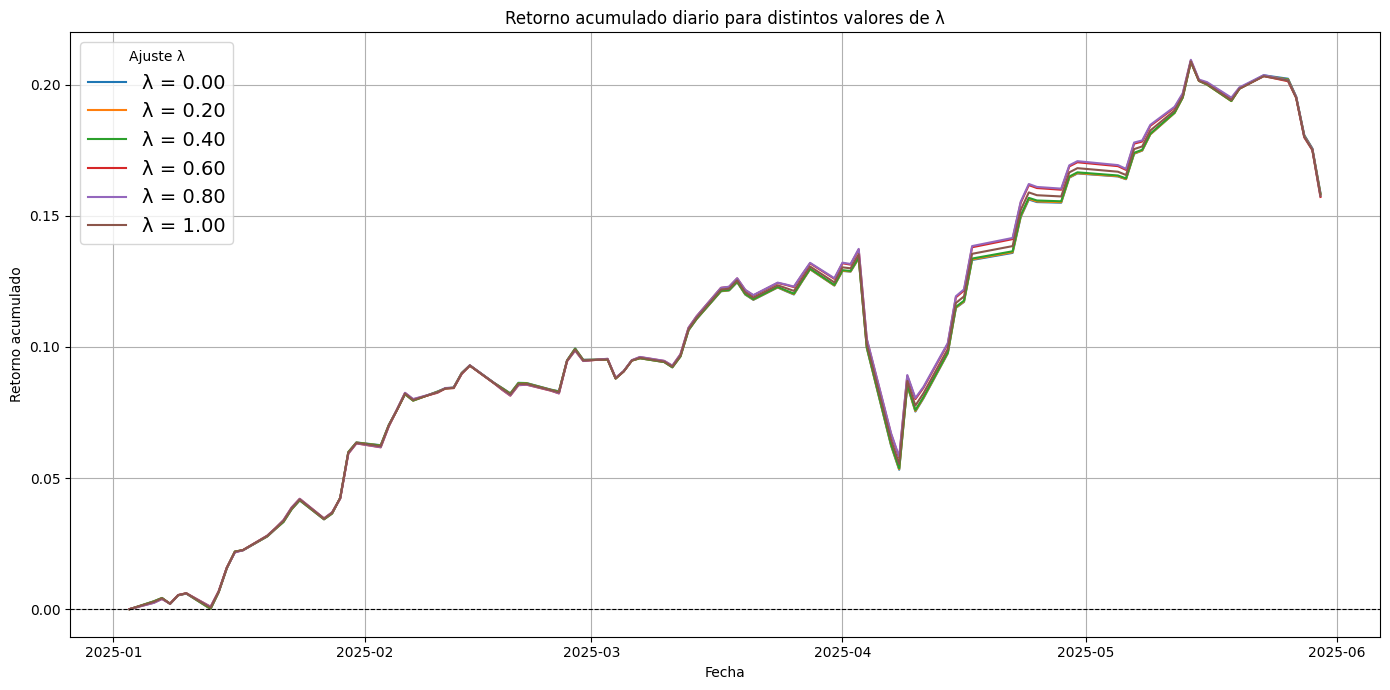

In [59]:
# --- SIMULACIÓN PARA GRID DE LAMBDA ---
lambdas = np.arange(0.0, 1.01, 0.2)
resultados_lambdas = {}

for lambda_ in lambdas:
    retornos_diarios_portafolio = []
    
    for fecha in retornos_2025.index:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_matrix_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        
        # Aplicar ajuste dinámico
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)

        # Matriz de covarianza ajustada
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_matrix_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        # Optimización
        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x
        retorno_dia = np.dot(pesos, retornos_2025.loc[fecha, activos_comunes].values)
        retornos_diarios_portafolio.append((fecha, retorno_dia))
    # Guardar resultados
    df_resultado = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_lambdas[lambda_] = df_resultado
    mostrar_resultados(res_min_var_adj, "Portafolio de Mínima Varianza (Ajustado)", cov_ajustada)

# --- GRAFICAR TODOS LOS RETORNOS ACUMULADOS ---
plt.figure(figsize=(14, 7))

for lambda_, df_sim in resultados_lambdas.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Retorno acumulado diario para distintos valores de λ")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="Ajuste λ", fontsize=14)
plt.tight_layout()
plt.show()

In [60]:
mean_returns

CMPC          0.000061
SMU           0.001052
RIPLEY        0.001187
ENTEL         0.000197
ECL           0.000896
ENELCHILE     0.000933
CONCHATORO   -0.000122
PARAUCO       0.001119
FALABELLA     0.000528
ITAUCL        0.012378
CCU          -0.000045
CAP          -0.000707
IAM           0.000883
SQM-B         0.000126
LTM          -0.003190
AGUAS-A       0.001048
ANDINA-B      0.000669
SALFACORP     0.000876
MALLPLAZA     0.000856
SONDA         0.000734
COLBUN        0.000828
COPEC        -0.000049
BSANTANDER    0.000583
ENELAM        0.000024
SECURITY      0.001139
VAPORES      -0.000323
CENCOSUD      0.000876
CHILE         0.000741
QUINENCO      0.001059
BCI           0.000337
dtype: float64

In [61]:
mean_returns

CMPC          0.000061
SMU           0.001052
RIPLEY        0.001187
ENTEL         0.000197
ECL           0.000896
ENELCHILE     0.000933
CONCHATORO   -0.000122
PARAUCO       0.001119
FALABELLA     0.000528
ITAUCL        0.012378
CCU          -0.000045
CAP          -0.000707
IAM           0.000883
SQM-B         0.000126
LTM          -0.003190
AGUAS-A       0.001048
ANDINA-B      0.000669
SALFACORP     0.000876
MALLPLAZA     0.000856
SONDA         0.000734
COLBUN        0.000828
COPEC        -0.000049
BSANTANDER    0.000583
ENELAM        0.000024
SECURITY      0.001139
VAPORES      -0.000323
CENCOSUD      0.000876
CHILE         0.000741
QUINENCO      0.001059
BCI           0.000337
dtype: float64

In [62]:
# Desplazar un día para incluir desde el día siguiente del mes anterior
retornos_shifted = retornos.shift(-1)

# Calcular retornos mensuales como suma de log-retornos diarios
retornos_mensuales = retornos_shifted.resample("MS").apply(lambda x: x.sum(skipna=True))

# Mostrar primeros valores
print(retornos_mensuales.head())

                CMPC       SMU    RIPLEY     ENTEL       ECL  ENELCHILE  \
Fecha                                                                     
2022-01-01  0.068993  0.084551  0.198367  0.122876  0.180557  -0.021459   
2022-02-01 -0.110337 -0.187755 -0.221506 -0.127468 -0.317354  -0.240437   
2022-03-01  0.115136  0.120628  0.061551  0.179499 -0.008547  -0.043530   
2022-04-01 -0.111090 -0.122484 -0.066027 -0.068061 -0.183191  -0.008992   
2022-05-01  0.143048  0.198581  0.137493 -0.026304  0.026270  -0.068464   

            CONCHATORO   PARAUCO  FALABELLA    ITAUCL  ...    COLBUN  \
Fecha                                                  ...             
2022-01-01   -0.009740  0.084248   0.108103  0.079763  ...  0.014926   
2022-02-01   -0.129257 -0.186425  -0.093537 -0.123113  ... -0.162119   
2022-03-01    0.116437  0.098892  -0.014605  0.103333  ...  0.136859   
2022-04-01   -0.030661 -0.146878  -0.064239  0.017863  ... -0.034701   
2022-05-01    0.051659  0.101995   0.02715

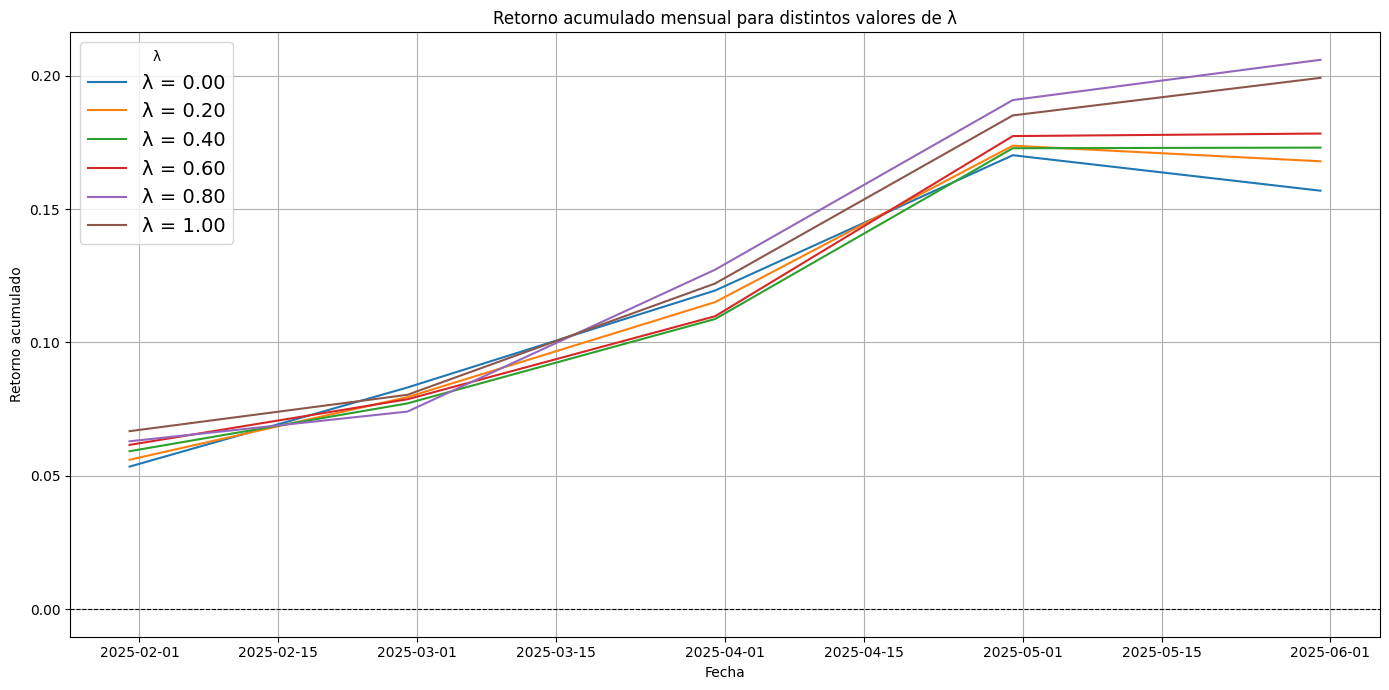

In [63]:
# --- Funciones ---
def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# --- Cargar datos ---
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
df_prob = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Probabilidades")

retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
retornos.columns = retornos.columns.str.strip().str.replace(".", "-")
# Desplazar un día para incluir desde el día siguiente del mes anterior
retornos_shifted = retornos.shift(-1)

# Calcular retornos mensuales como suma de log-retornos diarios
retornos = retornos_shifted.resample("MS").apply(lambda x: x.sum(skipna=True))

df_prob["Activo"] = df_prob["Activo"].str.strip()

# Filtrar activos comunes
activos_comunes = list(set(retornos.columns).intersection(df_prob["Activo"]))
retornos = retornos[activos_comunes]

df_prob = df_prob.set_index("Activo").loc[activos_comunes]

# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252
num_assets = len(activos_comunes)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# --- Simulación mensual para grid de lambda ---
lambdas = np.arange(0.0, 1.01, 0.2)
resultados_mensuales = {}

# Obtener el primer día hábil de cada mes en 2025
primeros_dias_mes = retornos_2025.resample('MS').first().dropna().index

for lambda_ in lambdas:
    retornos_portafolio = []
    
    for fecha in primeros_dias_mes:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x

        # Obtener retornos diarios desde fecha hasta fin de mes
        inicio = fecha
        fin = fecha + pd.offsets.MonthEnd(0)
        datos_mes = retornos_2025[(retornos_2025.index >= inicio) & (retornos_2025.index <= fin)]

        if datos_mes.empty:
            continue

        # Calcular retorno acumulado del mes (compuesto)
        retornos_dia = np.dot(datos_mes[activos_comunes].values, pesos)
        retorno_mes = (1 + retornos_dia).prod() - 1
        retornos_portafolio.append((fin, retorno_mes))

    # Crear DataFrame con resultados
    df_resultado = pd.DataFrame(retornos_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_mensuales[lambda_] = df_resultado

# --- Graficar ---
plt.figure(figsize=(14, 7))
for lambda_, df_sim in resultados_mensuales.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Retorno acumulado mensual para distintos valores de λ")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="λ", fontsize=14)
plt.tight_layout()
plt.show()


In [64]:
# Seleccionar los pesos del portafolio para lambda = 0 y lambda = 0.8 en la fecha 2025-05-01
fecha_objetivo = pd.Timestamp("2025-05-01")
lambdas = [0.0, 0.8]
pesos_dict = {}

for lambda_ in lambdas:
    # Filtrar datos de entrenamiento hasta la fecha objetivo
    datos_hasta_hoy = retornos_mensuales[retornos_mensuales.index < fecha_objetivo]
    if len(datos_hasta_hoy) < 2:
        continue

    mean_returns = datos_hasta_hoy.mean()
    cov_corr = datos_hasta_hoy.corr()
    std_original = datos_hasta_hoy.std()
    # Ajuste: se asume que df_prob ya está definido y alineado con las columnas
    ajuste = df_prob["Ajuste"]
    std_ajustada = std_original * (1 - lambda_ * ajuste)
    cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_corr
    cov_ajustada = pd.DataFrame(cov_ajustada, index=retornos_mensuales.columns, columns=retornos_mensuales.columns)

    res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    if res.success:
        pesos_dict[lambda_] = res.x

# Mostrar proporciones
for lambda_, pesos in pesos_dict.items():
    print(f"\nPesos del portafolio para lambda = {lambda_}:")
    proporciones = pd.Series(pesos, index=retornos_mensuales.columns)
    print(proporciones.round(4).sort_values(ascending=False))

    # Calcular retorno y riesgo usando los retornos mensuales de la fecha objetivo
    mean_returns = retornos_mensuales[retornos_mensuales.index < fecha_objetivo].mean()
    cov_matrix = retornos_mensuales[retornos_mensuales.index < fecha_objetivo].cov()
    retorno = np.dot(pesos, mean_returns)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))
    print(f"Retorno esperado: {retorno:.5f}")
    print(f"Riesgo (desviación estándar): {riesgo:.5f}")


Pesos del portafolio para lambda = 0.0:
CHILE         0.3092
ENELAM        0.2634
COPEC         0.1196
ENTEL         0.0800
CCU           0.0786
ANDINA-B      0.0605
COLBUN        0.0431
SECURITY      0.0323
BCI           0.0054
CMPC          0.0033
LTM           0.0020
CONCHATORO    0.0014
ITAUCL        0.0013
QUINENCO      0.0000
RIPLEY        0.0000
CENCOSUD      0.0000
VAPORES       0.0000
ECL           0.0000
ENELCHILE     0.0000
BSANTANDER    0.0000
PARAUCO       0.0000
CAP           0.0000
SONDA         0.0000
MALLPLAZA     0.0000
SALFACORP     0.0000
FALABELLA     0.0000
SMU           0.0000
SQM-B         0.0000
IAM           0.0000
AGUAS-A       0.0000
dtype: float64
Retorno esperado: 0.00947
Riesgo (desviación estándar): 0.03062

Pesos del portafolio para lambda = 0.8:
CHILE         0.2738
ENELAM        0.2083
SECURITY      0.1540
ANDINA-B      0.1065
CENCOSUD      0.1003
ENTEL         0.0488
COLBUN        0.0454
CMPC          0.0259
CONCHATORO    0.0187
COPEC         0.0172

C:\Users\sebastian\AppData\Local\Temp\ipykernel_14540\2569751957.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('2022-01-01', '2025-05-01', freq='M')


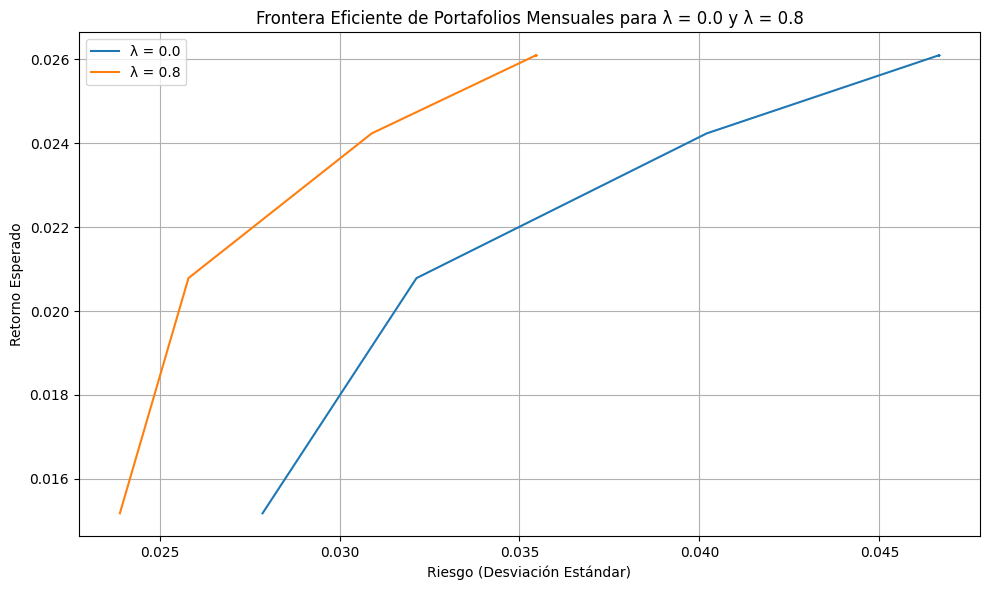

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def efficient_frontier(mean_returns, cov_matrix, num_points=100):
    results = np.zeros((2, num_points))
    for i, alpha in enumerate(np.linspace(0, 1, num_points)):
        target = alpha * mean_returns + (1 - alpha) * np.ones_like(mean_returns) * mean_returns.mean()
        constraints = ({
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
        },)
        bounds = tuple((0, 1) for _ in range(len(mean_returns)))
        result = minimize(lambda x: -np.dot(x, target),
                          x0=np.ones(len(mean_returns)) / len(mean_returns),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)
        if result.success:
            weights = result.x
            ret, risk = portfolio_performance(weights, mean_returns, cov_matrix)
            results[0, i] = risk
            results[1, i] = ret
    return results

# Usa tus datos reales de retornos_mensuales y df_prob
# Aquí hay un ejemplo con datos simulados
np.random.seed(0)
assets = ['A', 'B', 'C', 'D']
dates = pd.date_range('2022-01-01', '2025-05-01', freq='M')
retornos_mensuales = pd.DataFrame(np.random.normal(0.01, 0.05, (len(dates), len(assets))), columns=assets, index=dates)
df_prob = pd.DataFrame({'Ajuste': [0.2, 0.1, 0.15, 0.3]}, index=assets)

fecha_objetivo = pd.Timestamp("2025-05-01")
lambdas = [0.0, 0.8]
fronteras = {}

for lambda_ in lambdas:
    datos_hasta_hoy = retornos_mensuales[retornos_mensuales.index < fecha_objetivo]
    mean_returns = datos_hasta_hoy.mean()
    cov_corr = datos_hasta_hoy.corr()
    std_original = datos_hasta_hoy.std()
    ajuste = df_prob["Ajuste"]
    std_ajustada = std_original * (1 - lambda_ * ajuste)
    cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_corr
    cov_ajustada = pd.DataFrame(cov_ajustada, index=assets, columns=assets)
    fronteras[lambda_] = efficient_frontier(mean_returns, cov_ajustada)

plt.figure(figsize=(10, 6))
for lambda_, frontier in fronteras.items():
    plt.plot(frontier[0], frontier[1], label=f'λ = {lambda_:.1f}')
plt.title('Frontera Eficiente de Portafolios Mensuales para λ = 0.0 y λ = 0.8')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
